Étape 4 : Prétraitement des Données


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("customer-churn-prediction-spark") \
    .master("local[*]")\
    .getOrCreate()

# Vérifier la version de Spark
spark

In [2]:
DATA = "../Data/Raw/dataSpark.csv"
df = spark.read.csv(DATA, header=True, inferSchema=True)



Suppression des colonnes non pertinentes.


In [3]:
df = df.drop("RowNumber", "CustomerId", "Surname")

 Gerer valeurs manquantes

Normalement on a pas des valeurs manquantes 

In [5]:
from pyspark.ml.feature import Imputer

typeData=df.dtypes
cols_num=[x[0] for x in typeData if x [1] != 'string']
print(cols_num)

imputer = Imputer(
    inputCols=cols_num,
    outputCols=cols_num
).setStrategy("median")

df= imputer.fit(df).transform(df)
df.show(5)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|
|        850|    Spain|Female| 43|     2|125510.82|            1|        1|      

Gerer les outliers

In [6]:
# Supprimer les lignes où Age > upper
# Suppression des ages qui sont superieur à 86
q1_age, q3_age = df.approxQuantile("Age", [0.25, 0.75], 0.01)
iqr_age = q3_age - q1_age
lower_age = q1_age - 1.7 * iqr_age
upper_age = q3_age + 3.5 * iqr_age

df = df.filter(df['Age'] <= upper_age)


In [7]:
from pyspark.sql import functions as F

# Pour le reste outliers on va le gerer par le capping 

q1_age, q3_age = df.approxQuantile("Age", [0.25, 0.75], 0.01)
iqr_age = q3_age - q1_age
lower_age = q1_age - 1.7 * iqr_age
upper_age = q3_age + 2.8 * iqr_age

df = df.withColumn(
    "Age",
    F.when(F.col("Age") < lower_age, lower_age)
     .when(F.col("Age") > upper_age, upper_age)
     .otherwise(F.col("Age"))
)

q1_cs, q3_cs = df.approxQuantile("CreditScore", [0.25, 0.75], 0.01)
iqr_cs = q3_cs - q1_cs
lower_cs = q1_cs - 1.5 * iqr_cs
upper_cs = q3_cs + 1.5 * iqr_cs

df = df.withColumn(
    "CreditScore",
    F.when(F.col("CreditScore") < lower_cs, lower_cs)
     .when(F.col("CreditScore") > upper_cs, upper_cs)
     .otherwise(F.col("CreditScore"))
)

df.select("Age", "CreditScore").describe().show()


+-------+------------------+-----------------+
|summary|               Age|      CreditScore|
+-------+------------------+-----------------+
|  count|              9997|             9997|
|   mean|38.900430129038696|650.5692707812344|
| stddev|10.428053631241973|96.52928202837722|
|    min|              18.0|            389.0|
|    max|              77.6|            850.0|
+-------+------------------+-----------------+



C:\Users\elabi\AppData\Local\Temp\ipykernel_14424\1402594000.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


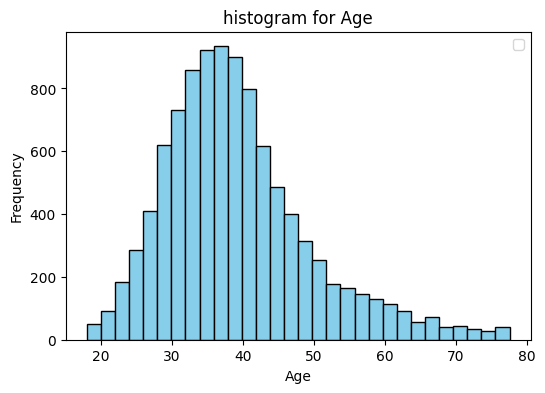

In [8]:
import matplotlib.pyplot as plt

numeric_pd = df.toPandas()

plt.figure(figsize=(6,4))
plt.hist(numeric_pd["Age"] , bins = 30 , color='skyblue', edgecolor='black')
plt.xlabel("Age")
plt.title(f"histogram for {"Age"}")
plt.ylabel("Frequency")
plt.legend()
plt.show()

C:\Users\elabi\AppData\Local\Temp\ipykernel_14424\3000032865.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


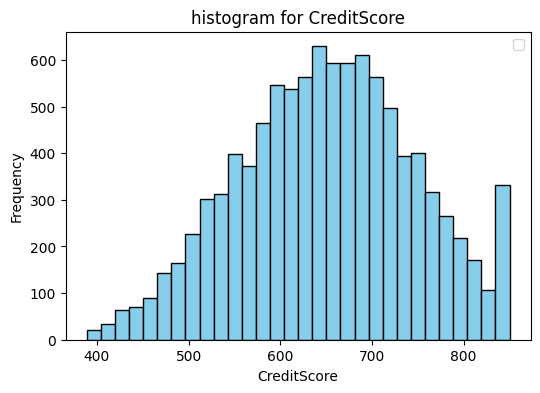

In [9]:
plt.figure(figsize=(6,4))
plt.hist(numeric_pd["CreditScore"] , bins = 30 , color='skyblue', edgecolor='black')
plt.xlabel("CreditScore")
plt.title(f"histogram for {"CreditScore"}")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Encodage des variables catégorielles (StringIndexer, OneHotEncoder)


        StringIndexer 

In [10]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(
    inputCols=["Gender", "Geography"],
    outputCols=["GenderIndex", "GeographyIndex"]
)
df_indexed = indexer.fit(df).transform(df)


        OneHotEncoder

In [11]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(
    inputCols=["GenderIndex", "GeographyIndex"],
    outputCols=["GenderBv", "GeographyBc"]
)
df_encoded = encoder.fit(df_indexed).transform(df_indexed)


In [14]:
df_indexed.show(5)

+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+-----------+--------------+
|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|GenderIndex|GeographyIndex|
+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+-----------+--------------+
|      619.0|   France|Female|42.0|     2|      0.0|            1|        1|             1|      101348.88|     1|        1.0|           0.0|
|      608.0|    Spain|Female|41.0|     1| 83807.86|            1|        0|             1|      112542.58|     0|        1.0|           2.0|
|      502.0|   France|Female|42.0|     8| 159660.8|            3|        1|             0|      113931.57|     1|        1.0|           0.0|
|      699.0|   France|Female|39.0|     1|      0.0|            2|        0|             0|       93826.63|     0|        1.0|           0.0|
|     

In [16]:
df_encoded.show(5)

+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+-----------+--------------+---------+-------------+
|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|GenderIndex|GeographyIndex| GenderBv|  GeographyBc|
+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+-----------+--------------+---------+-------------+
|      619.0|   France|Female|42.0|     2|      0.0|            1|        1|             1|      101348.88|     1|        1.0|           0.0|(1,[],[])|(2,[0],[1.0])|
|      608.0|    Spain|Female|41.0|     1| 83807.86|            1|        0|             1|      112542.58|     0|        1.0|           2.0|(1,[],[])|    (2,[],[])|
|      502.0|   France|Female|42.0|     8| 159660.8|            3|        1|             0|      113931.57|     1|        1.0|           0.0|(1,[],[])|(2,[0],[1.0])|
|   

In [17]:
df_encoded.toPandas().to_csv("../Data/Processed/data.csv", index=False, header=True)


In [ ]:
spark.stop()